In [271]:
from utils.util import *
from matplotlib import pyplot as plt
import torch.optim as optim
import gc
import numpy as np
# Set seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

## raw data

In [272]:
data = Loader(data_dir="data").load_csv(file_name="Churn_Modelling.csv")
# data1 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="bureau_balance.csv")
# data2 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="bureau.csv")
# data3 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="credit_card_balance.csv")
# data4 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="HomeCredit_columns_description.csv")
# data5 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="installments_payments.csv")
# data6 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="POS_CASH_balance.csv")
# data7 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="previous_application.csv")
# data8 = Loader(data_dir="data/home-credit-default-risk").load_csv(file_name="sample_submission.csv")

In [273]:
datacp = data.copy()

In [275]:
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [325]:
unfair_features = "Age"
target = "Exited"

## pre process

In [291]:
data = data.drop(columns=["RowNumber", "CustomerId", "Surname"]) # drop unuseage column
# data = data[list(set(important_features + unfairness_risk_features + target))] # reorder columns
# Identify columns with more than 10,000 missing values

# cols_to_drop = [col for col in data.columns if data[col].isnull().sum() > 10000] + ["SK_ID_CURR"]
# Drop those columns
# data = data.drop(columns=cols_to_drop)
# data = data[data["Gender"] != "Gender"] # drop rows with unknown
data = data.dropna() # drop rows with missing values
data = data.drop_duplicates() # drop duplicates
data = data.reset_index(drop=True)

In [294]:
from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()

# Encode categorical columns
categorical_columns = list(data.select_dtypes(include=['object']).columns)
for column in categorical_columns:
    data[column] = le.fit_transform(data[column])

    # Reindex rows
    data = data.reset_index(drop=True)

# One-hot encode the 'Geography' column
# data = pd.get_dummies(data, columns=['Geography'], drop_first=False,dtype='int64')

data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [326]:
if unfair_features != "Age":
    datainv = data.copy()
    num_cls = len(datacp[unfair_features].unique())
    datainv[unfair_features] = datainv[unfair_features].apply(lambda x: (x + 1) % num_cls) #invert columns CODE_GENDER
else:
    print("Age")
    datainv = data.copy()
    num_cls = len(datacp[unfair_features].unique())
    min = datacp[unfair_features].unique().min()
    max = datacp[unfair_features].unique().max()
    # datainv[unfair_features] = datainv[unfair_features].apply(lambda x: ((x - min) + 1) % (max - min)) #invert columns CODE_GENDER
    datainv[unfair_features] = datainv[unfair_features].apply(lambda x: max - (x - min)) #invert columns CODE_GENDER
    # datainv = data.copy()
    # num_cls = len(datacp[unfair_features].unique())
    # choice = datacp[unfair_features].values.tolist()
    # for i in range(len(datainv[unfair_features].values)):
    #     cc = np.random.choice(choice)
    #     choice.pop(choice.index(cc))
    #     datainv[unfair_features][i] = cc # revalue by random value from list

Age


In [329]:
DatasetL = DataSet(data=data, y_col=target)
train_data, test_data = DatasetL.get_datasets()
train_data_L, val_data_L = DatasetL.get_dataloaders(batch_size=128)

In [330]:
DatasetInvL = DataSet(data=datainv, y_col=target)
train_dataInv, test_dataInv = DatasetInvL.get_datasets()

# Model

## Model Unfairness

In [37]:
model = NeuralNetwork(d = 32, input = 10, output = 2, drop=0.5).to(device) # 4 0.0

# Define the loss function and optimizer
# class_counts = torch.bincount(torch.argmax(train_data.y,dim=1))  # Count samples per class
# class_counts[1] = class_counts[1] * 1000
# class_weights = 1.0 / class_counts.float()  # Inverse class frequency
# class_weights = class_weights / class_weights.sum()  # Normalize
# criterion = nn.BCELoss(weight=class_weights.to(device),reduction='mean')
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1.0e-5, weight_decay=0, amsgrad=False, eps=1.0e-8, betas=(0.9, 0.999), maximize=False)
model.eval()

NeuralNetwork(
  (layer1): Linear(in_features=10, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=2, bias=True)
  (silu): SiLU()
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (normalization1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization0): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)

In [227]:
model.load_state_dict(torch.load("model/model_bank1.pth"))

<All keys matched successfully>

### train model

In [ ]:
object_max = 0

In [ ]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    all_loss = []
    avg_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_data_L):
        inputs, targets = inputs.to(0), targets.to(0)
    # for i, data in enumerate(train_data_DL):
    #     inputs, targets = data
    #     inputs, targets = inputs.to(device), targets.to(device)
        if inputs.size(0) == 1:
            continue
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.float())
        # all_loss.append(criterion_T(outputs, targets.float()).item())
        all_loss.append(loss.item())
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    # optimizer.zero_grad()
    
    # # Forward pass
    # outputs = model(train_data.X)
    # loss = criterion(outputs, train_data.y.float())
    
    # # Backward pass and optimization
    # loss.backward()
    # optimizer.step()
    
    if (epoch+1) % 1 == 0:
        avg_loss = sum(all_loss) / len(all_loss)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        model.eval()
        with torch.no_grad():
            # Forward pass
            test_outputs = model(test_data.X)
    
            # Calculate the loss
            test_loss = criterion(test_outputs, test_data.y.float())
    
            # Calculate accuracy
            predicted = torch.argmax(test_outputs, 1)
            labels = torch.argmax(test_data.y, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracy_f = (predicted == labels)[DatasetL.X_test[unfair_features].values == 0].sum().item() / labels[DatasetL.X_test[unfair_features].values == 0].size(0)
            accuracy_m = (predicted == labels)[DatasetL.X_test[unfair_features].values == 1].sum().item() / labels[DatasetL.X_test[unfair_features].values == 1].size(0)
            accuracy_0 = (predicted[labels == 0] == labels[labels == 0]).sum().item() / labels[labels == 0].size(0)
            accuracy_1 = (predicted[labels == 1] == labels[labels == 1]).sum().item() / labels[labels == 1].size(0)
            # print(f'Test Accuracy for class 0: {accuracy_0 * 100:.2f}%, Test Accuracy for class 1: {accuracy_1 * 100:.2f}%')
            obj_max = ((accuracy_0 + accuracy_1)*100) #/ (abs(accuracy_0 - accuracy_1) * 100)
            if obj_max > object_max:
                object_max = obj_max
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
                torch.save(model.state_dict(), "model/model_bank1.pth")
                print(f'Test Accuracy for class 0: {accuracy_0 * 100:.2f}%, Test Accuracy for class 1: {accuracy_1 * 100:.2f}%')
                print(f"object_max: {object_max * 100:.2f}%")

                print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
                # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    
                print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Epoch [1/400], Loss: 0.6956
Test Accuracy for class 0: 26.01%, Test Accuracy for class 1: 86.51%
object_max: 11252.52%
Test Loss: 0.7060, Test Accuracy: 31.87%, 45.19%
Test Loss: 0.7060, Test Accuracy: 37.90%
Epoch [2/400], Loss: 0.6922
Test Accuracy for class 0: 31.99%, Test Accuracy for class 1: 83.46%
object_max: 11544.56%
Test Loss: 0.7014, Test Accuracy: 36.71%, 48.62%
Test Loss: 0.7014, Test Accuracy: 42.10%
Epoch [3/400], Loss: 0.6833
Test Accuracy for class 0: 34.29%, Test Accuracy for class 1: 84.22%
object_max: 11851.14%
Test Loss: 0.6997, Test Accuracy: 38.90%, 50.39%
Test Loss: 0.6997, Test Accuracy: 44.10%
Epoch [4/400], Loss: 0.6767
Test Accuracy for class 0: 40.01%, Test Accuracy for class 1: 81.42%
object_max: 12143.74%
Test Loss: 0.6935, Test Accuracy: 43.84%, 53.37%
Test Loss: 0.6935, Test Accuracy: 48.15%
Epoch [5/400], Loss: 0.6710
Test Accuracy for class 0: 47.42%, Test Accuracy for class 1: 78.37%
object_max: 12578.90%
Test Loss: 0.6859, Test Accuracy: 49.41%, 58.

In [ ]:
#32
# Test Accuracy for class 0: 76.17%, Test Accuracy for class 1: 77.61%
# object_max: 15377.49%
# Test Loss: 0.5429, Test Accuracy: 81.10%, 70.83%
# Test Loss: 0.5429, Test Accuracy: 76.45%

# 64
# Test Accuracy for class 0: 75.11%, Test Accuracy for class 1: 74.81%
# object_max: 50016.32%
# Test Loss: 0.5617, Test Accuracy: 80.00%, 69.06%
# Test Loss: 0.5617, Test Accuracy: 75.05%

# Test Accuracy for class 0: 75.92%, Test Accuracy for class 1: 77.61%
# object_max: 15352.60%
# Test Loss: 0.5187, Test Accuracy: 81.28%, 70.17%
# Test Loss: 0.5187, Test Accuracy: 76.25%



#-------------------------------------------------------------------- encode
#16
# Test Accuracy for class 0: 80.09%, Test Accuracy for class 1: 74.81%
# object_max: 15489.63%
# Test Loss: 0.5074, Test Accuracy: 84.29%, 72.71%
# Test Loss: 0.5074, Test Accuracy: 79.05%

#16
# Test Accuracy for class 0: 72.56%, Test Accuracy for class 1: 77.86%
# object_max: 15042.02%
# Test Loss: 0.5548, Test Accuracy: 80.73%, 64.97%
# Test Loss: 0.5548, Test Accuracy: 73.60%

In [ ]:
# torch.save(model.state_dict(), 'model/model_bank1.pth')

### test model 

In [331]:
# Evaluation loop
model.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = model(test_data.X)

    # Calculate the loss
    test_loss = criterion(test_outputs, test_data.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_data.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    # accuracy_f = (predicted == labels)[DatasetL.X_test[unfair_features].values == 0].sum().item() / labels[DatasetL.X_test[unfair_features].values == 0].size(0)
    # accuracy_m = (predicted == labels)[DatasetL.X_test[unfair_features].values == 1].sum().item() / labels[DatasetL.X_test[unfair_features].values == 1].size(0)
    # print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.5406, Test Accuracy: 74.80%


In [332]:
out_L_0 = []
lab_0 = []
if unfair_features != "Age":
    for i,d in enumerate(sorted(datacp[unfair_features].unique())):
        out_L_0.append(predicted[DatasetL.X_test[unfair_features].values == i].cpu())
        lab_0.append(d)
else:
    for i,d in enumerate(sorted(pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).unique())):
        out_L_0.append(predicted[pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).values == i].cpu())
        lab_0.append(d)

In [333]:
# men_0 = predicted[DatasetL.X_test[unfair_features].values == 0]
# women_0 = predicted[DatasetL.X_test[unfair_features].values == 1]

In [334]:
# Evaluation loop
model.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = model(test_dataInv.X)

    # Calculate the loss
    test_loss = criterion(test_outputs, test_dataInv.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_dataInv.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    # accuracy_f = (predicted == labels)[DatasetInvL.X_test[unfair_features].values == 0].sum().item() / labels[DatasetInvL.X_test[unfair_features].values == 0].size(0)
    # accuracy_m = (predicted == labels)[DatasetInvL.X_test[unfair_features].values == 1].sum().item() / labels[DatasetInvL.X_test[unfair_features].values == 1].size(0)
    # print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.6235, Test Accuracy: 65.65%


In [335]:
# men_1 = predicted[DatasetInvL.X_test[unfair_features].values == 0]
# women_1 = predicted[DatasetInvL.X_test[unfair_features].values == 1]

In [336]:
# import numpy as np
# not_left = np.array([len(men_0[men_0 == 0]), len(women_0[women_0 == 0]), len(men_1[men_1 == 0]), len(women_1[women_1 == 0])])
# left = np.array([len(men_0[men_0 == 1]), len(women_0[women_0 == 1]), len(men_1[men_1 == 1]), len(women_1[women_1 == 1])])
# not_leftp = np.round(not_left/(not_left + left)*100)
# leftp = np.round(left/(left + not_left)*100)

In [337]:
out_L_1 = []
lab_1 = []
if unfair_features != "Age":
    for i,d in enumerate(sorted(datacp[unfair_features].unique())):
        out_L_1.append(predicted[DatasetL.X_test[unfair_features].values == i].cpu())
        lab_1.append(d)
else:
    for i,d in enumerate(sorted(pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).unique())):
        out_L_1.append(predicted[pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).values == i].cpu())
        lab_1.append(d)

In [338]:
import numpy as np
not_left = np.array([len(OL0) - sum(OL0) for OL0 in out_L_0] + [len(OL1) - sum(OL1) for OL1 in out_L_1])
left = np.array([sum(OL0) for OL0 in out_L_0] + [sum(OL1) for OL1 in out_L_1])
not_leftp = np.round(not_left/(not_left + left)*100)
leftp = np.round(left/(left + not_left)*100)

In [339]:
comdata = list(zip(not_leftp,leftp))

In [340]:
comdata

[(np.float64(99.0), np.float64(1.0)),
 (np.float64(90.0), np.float64(10.0)),
 (np.float64(69.0), np.float64(31.0)),
 (np.float64(35.0), np.float64(65.0)),
 (np.float64(31.0), np.float64(69.0)),
 (np.float64(56.0), np.float64(44.0)),
 (np.float64(76.0), np.float64(24.0)),
 (np.float64(67.0), np.float64(33.0)),
 (np.float64(100.0), np.float64(0.0)),
 (np.float64(100.0), np.float64(0.0)),
 (np.float64(84.0), np.float64(16.0)),
 (np.float64(72.0), np.float64(28.0)),
 (np.float64(56.0), np.float64(44.0)),
 (np.float64(46.0), np.float64(54.0)),
 (np.float64(46.0), np.float64(54.0)),
 (np.float64(40.0), np.float64(60.0)),
 (np.float64(57.0), np.float64(43.0)),
 (np.float64(61.0), np.float64(39.0)),
 (np.float64(100.0), np.float64(0.0)),
 (np.float64(100.0), np.float64(0.0))]

            0         |         1

    [(np.float64(58.0), np.float64(42.0)),
    (np.float64(71.0), np.float64(29.0)),

    (np.float64(66.0), np.float64(34.0)),
    (np.float64(62.0), np.float64(38.0))]

    --------------------------------------------

    [(np.float64(69.0), np.float64(31.0)),
    (np.float64(46.0), np.float64(54.0)),
    (np.float64(76.0), np.float64(24.0)),

    (np.float64(60.0), np.float64(40.0)),
    (np.float64(67.0), np.float64(33.0)),
    (np.float64(68.0), np.float64(32.0))]

    -------------------------------------------
    
    [(np.float64(99.0), np.float64(1.0)),
    (np.float64(90.0), np.float64(10.0)),
    (np.float64(69.0), np.float64(31.0)),
    (np.float64(35.0), np.float64(65.0)),
    (np.float64(31.0), np.float64(69.0)),
    (np.float64(56.0), np.float64(44.0)),
    (np.float64(76.0), np.float64(24.0)),
    (np.float64(67.0), np.float64(33.0)),
    (np.float64(100.0), np.float64(0.0)),
    (np.float64(100.0), np.float64(0.0)),

    (np.float64(84.0), np.float64(16.0)),
    (np.float64(72.0), np.float64(28.0)),
    (np.float64(56.0), np.float64(44.0)),
    (np.float64(46.0), np.float64(54.0)),
    (np.float64(46.0), np.float64(54.0)),
    (np.float64(40.0), np.float64(60.0)),
    (np.float64(57.0), np.float64(43.0)),
    (np.float64(61.0), np.float64(39.0)),
    (np.float64(100.0), np.float64(0.0)),
    (np.float64(100.0), np.float64(0.0))]
    | Not Left (%) | Left (%) |
    |--------------|----------|
    | 58.0         | 42.0     |
    | 71.0         | 29.0     |
    | 66.0         | 34.0     |
    | 62.0         | 38.0     |
    |--------------|----------|
    | 69.0         | 31.0     |
    | 46.0         | 54.0     |
    | 76.0         | 24.0     |
    | 60.0         | 40.0     |
    | 67.0         | 33.0     |
    | 68.0         | 32.0     |
    |--------------|----------|
    | 99.0         | 1.0      |
    | 90.0         | 10.0     |
    | 69.0         | 31.0     |
    | 35.0         | 65.0     |
    | 31.0         | 69.0     |
    | 56.0         | 44.0     |
    | 76.0         | 24.0     |
    | 67.0         | 33.0     |
    | 100.0        | 0.0      |
    | 100.0        | 0.0      |
    | 84.0         | 16.0     |
    | 72.0         | 28.0     |
    | 56.0         | 44.0     |
    | 46.0         | 54.0     |
    | 46.0         | 54.0     |
    | 40.0         | 60.0     |
    | 57.0         | 43.0     |
    | 61.0         | 39.0     |
    | 100.0        | 0.0      |
    | 100.0        | 0.0      |

| Not Left (%) | Left (%) |
|--------------|----------|
| 58.0         | 42.0     |
| 71.0         | 29.0     |

| Not Left (%) | Left (%) |
|--------------|----------|
| 66.0         | 34.0     |
| 62.0         | 38.0     |
--------------------------
| Not Left (%) | Left (%) |
|--------------|----------|
| 69.0         | 31.0     |
| 46.0         | 54.0     |
| 76.0         | 24.0     |

| Not Left (%) | Left (%) |
|--------------|----------|
| 60.0         | 40.0     |
| 67.0         | 33.0     |
| 68.0         | 32.0     |
-----------------------------
| Not Left (%) | Left (%) |
|--------------|----------|
| 99.0         | 1.0      |
| 90.0         | 10.0     |
| 69.0         | 31.0     |
| 35.0         | 65.0     |
| 31.0         | 69.0     |
| 56.0         | 44.0     |
| 76.0         | 24.0     |
| 67.0         | 33.0     |
| 100.0        | 0.0      |
| 100.0        | 0.0      |

| Not Left (%) | Left (%) |
|--------------|----------|
| 84.0         | 16.0     |
| 72.0         | 28.0     |
| 56.0         | 44.0     |
| 46.0         | 54.0     |
| 46.0         | 54.0     |
| 40.0         | 60.0     |
| 57.0         | 43.0     |
| 61.0         | 39.0     |
| 100.0        | 0.0      |
| 100.0        | 0.0      |

### plot compair [feature target]

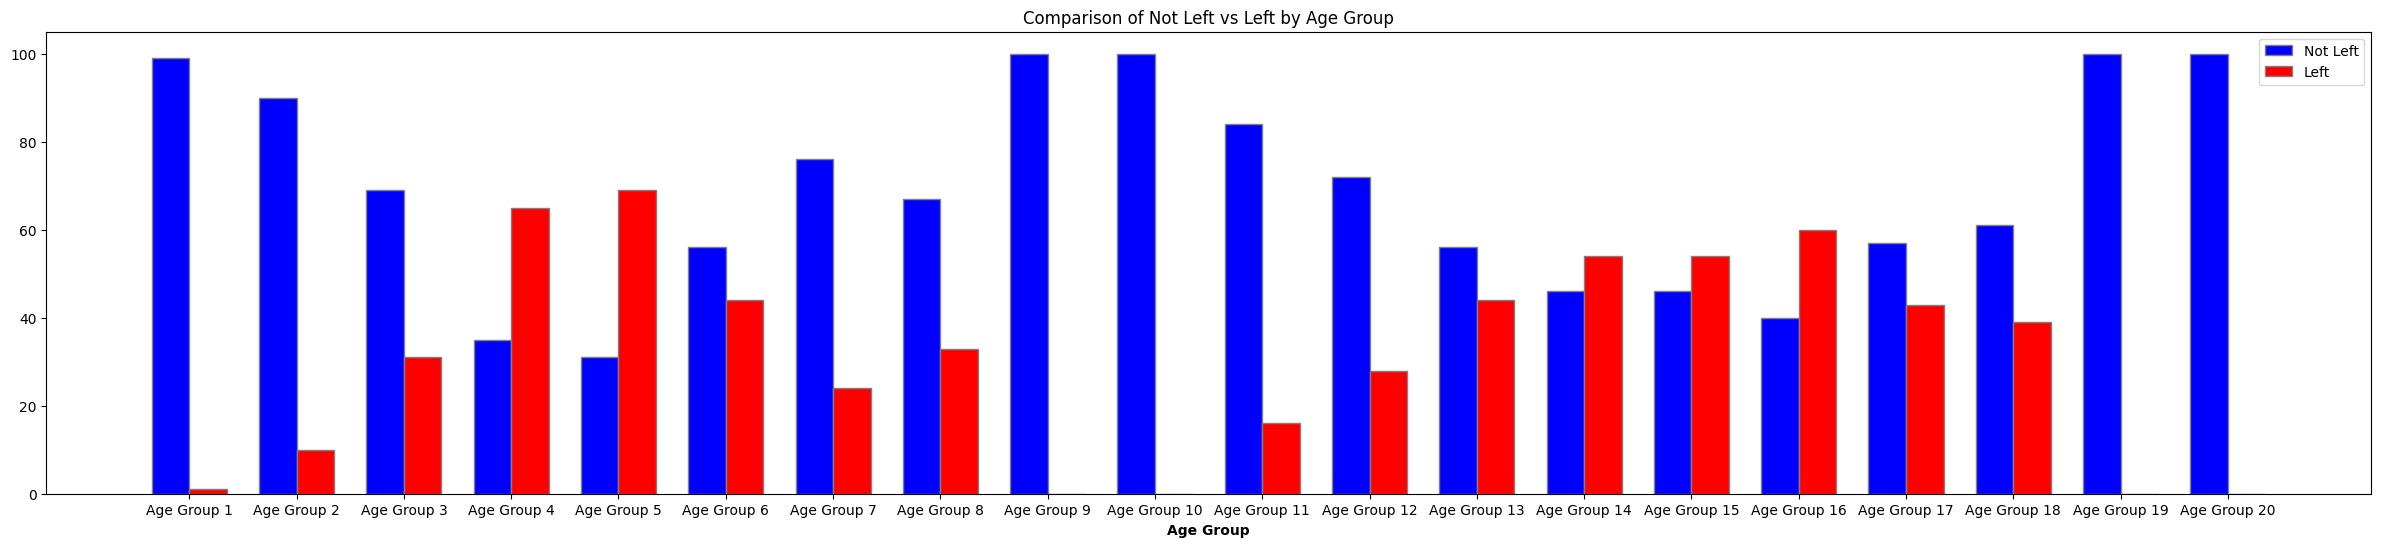

In [154]:
import matplotlib.pyplot as plt

# Define the labels for the bars
labels = [f'Age Group {i+1}' for i in range(len(comdata))]

# Unzip the comdata into two separate lists
not_left, left = zip(*comdata)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(not_left))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.figure(figsize=(30, 6))
plt.bar(r1, not_left, color='blue', width=bar_width, edgecolor='grey', label='Not Left')
plt.bar(r2, left, color='red', width=bar_width, edgecolor='grey', label='Left')

# Add labels to the x-axis
plt.xlabel('Age Group', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(not_left))], labels)

# Add a title and legend
plt.title('Comparison of Not Left vs Left by Age Group')
plt.legend()

# Show the plot
plt.show()

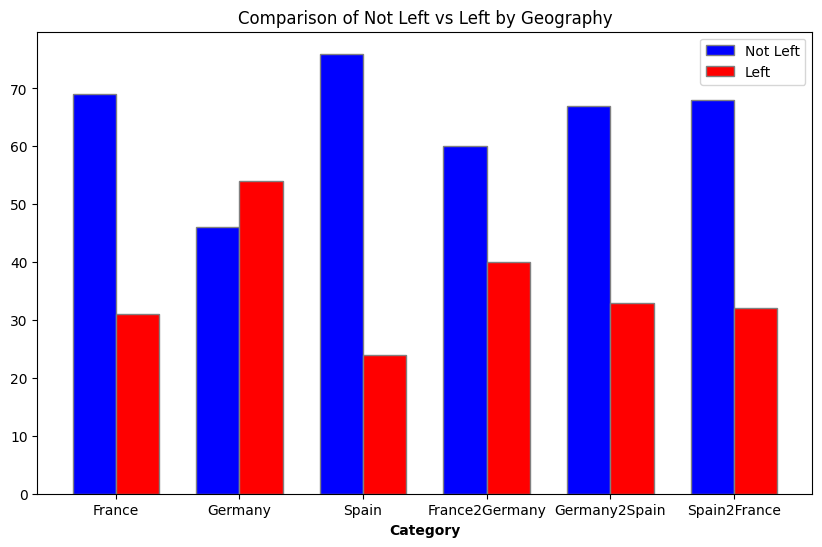

In [170]:
import matplotlib.pyplot as plt

# Define the labels for the bars
labels = ['France', 'Germany', 'Spain', 'France2Germany', 'Germany2Spain', 'Spain2France']

# Unzip the comdata into two separate lists
not_left, left = zip(*comdata)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(not_left))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(r1, not_left, color='blue', width=bar_width, edgecolor='grey', label='Not Left')
plt.bar(r2, left, color='red', width=bar_width, edgecolor='grey', label='Left')

# Add labels to the x-axis
plt.xlabel('Category', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(not_left))], labels)

# Add a title and legend
plt.title('Comparison of Not Left vs Left by Geography')
plt.legend()

# Show the plot
plt.show()

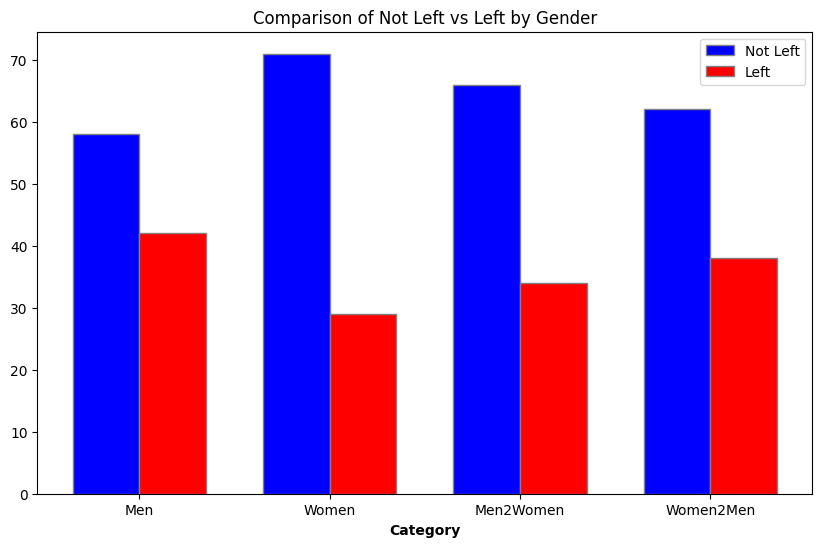

In [236]:
import matplotlib.pyplot as plt

# Define the labels for the bars
labels = ['Men', 'Women', 'Men2Women', 'Women2Men']

# Unzip the comdata into two separate lists
not_left, left = zip(*comdata)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(not_left))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(r1, not_left, color='blue', width=bar_width, edgecolor='grey', label='Not Left')
plt.bar(r2, left, color='red', width=bar_width, edgecolor='grey', label='Left')

# Add labels to the x-axis
plt.xlabel('Category', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(not_left))], labels)

# Add a title and legend
plt.title('Comparison of Not Left vs Left by Gender')
plt.legend()

# Show the plot
plt.show()

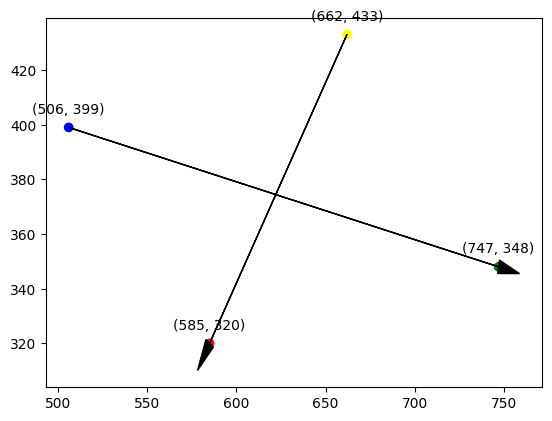

In [ ]:
# x = [len(men_0[men_0 == 0]), len(women_0[women_0 == 0]), len(men_1[men_1 == 0]), len(women_1[women_1 == 0])]
# y = [len(men_0[men_0 == 1]), len(women_0[women_0 == 1]), len(men_1[men_1 == 1]), len(women_1[women_1 == 1])]
# plt.figure(0)
# plt.scatter(x, y,c=['blue', 'green', 'yellow', 'red'])
# # plt.plot(x[:2], y[:2], 'k-', lw=2)
# plt.arrow(x[0], y[0], x[1] - x[0], y[1] - y[0], head_width=5, head_length=12, fc='k', ec='k')
# plt.arrow(x[2], y[2], x[3] - x[2], y[3] - y[2], head_width=5, head_length=12, fc='k', ec='k')
# for i in range(len(x)):
#     plt.annotate(f'({x[i]}, {y[i]})', (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
# plt.savefig("outputs/output_with_Gender_unfairness_bank1.png")
# # plt.plot(x[2:], y[2:], 'k-', lw=2)

In [ ]:
###Drop gender columns

## Model fairness

In [103]:
DatasetL = DataSet(data=data, y_col=target)
train_data, test_data = DatasetL.get_datasets()
train_data_L, val_data_L = DatasetL.get_dataloaders(batch_size=64)

In [108]:
modelD = NeuralNetwork(d = 32, input = 7, output = 2, drop=0.5).to(device) # 4 0.0

# Define the loss function and optimizer
# class_counts = torch.bincount(torch.argmax(train_data.y,dim=1))  # Count samples per class
# class_counts[1] = class_counts[1] * 1000
# class_weights = 1.0 / class_counts.float()  # Inverse class frequency
# class_weights = class_weights / class_weights.sum()  # Normalize
# criterion = nn.BCELoss(weight=class_weights.to(device),reduction='mean')
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(modelD.parameters(), lr=1.0e-5, weight_decay=0, amsgrad=False, eps=1.0e-8, betas=(0.9, 0.999), maximize=False)
modelD.eval()

NeuralNetwork(
  (layer1): Linear(in_features=7, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=2, bias=True)
  (silu): SiLU()
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (normalization1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (normalization3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sigmoid): Sigmoid()
)

In [ ]:
modelD.load_state_dict(torch.load("model/model_bank1D.pth"))

<All keys matched successfully>

### train model

In [ ]:
object_max = 0

In [114]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    modelD.train()
    # for batch_idx, (inputs, targets) in enumerate(train_loader):
    #    inputs, targets = inputs.to(0), targets.to(0)
    all_loss = []
    avg_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_data_L):
        inputs, targets = inputs.to(0), targets.to(0)
    # for i, data in enumerate(train_data_L):
    #     inputs, targets = data
    #     inputs, targets = inputs.to(device), targets.to(device)
        if inputs.size(0) == 1:
            continue
        # Zero the gradients
        optimizer.zero_grad()
    
        # Forward pass
        outputs = modelD(inputs[:, [i for i in range(inputs.shape[1]) if i != 3 and i != 2 and i != 1]])
        loss = criterion(outputs, targets.float())
        # all_loss.append(criterion_T(outputs, targets.float()).item())
        all_loss.append(loss.item())
    
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    # optimizer.zero_grad()
    
    # # Forward pass
    # outputs = modelD(train_data.X[:, [i for i in range(train_data.X.shape[1]) if i != 1]])
    # loss = criterion(outputs, train_data.y.float())
    
    # # Backward pass and optimization
    # loss.backward()
    # optimizer.step()
    
    if (epoch+1) % 1 == 0:
        avg_loss = sum(all_loss) / len(all_loss)
        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
        modelD.eval()
        with torch.no_grad():
            # Forward pass
            test_outputs = modelD(test_data.X[:, [i for i in range(test_data.X.shape[1]) if i != 3 and i != 2 and i != 1]])
    
            # Calculate the loss
            test_loss = criterion(test_outputs, test_data.y.float())
    
            # Calculate accuracy
            predicted = torch.argmax(test_outputs, 1)
            labels = torch.argmax(test_data.y, 1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            # accuracy_f = (predicted == labels)[DatasetL.X_test[unfair_features].values == 0].sum().item() / labels[DatasetL.X_test[unfair_features].values == 0].size(0)
            # accuracy_m = (predicted == labels)[DatasetL.X_test[unfair_features].values == 1].sum().item() / labels[DatasetL.X_test[unfair_features].values == 1].size(0)
            accuracy_0 = (predicted[labels == 0] == labels[labels == 0]).sum().item() / labels[labels == 0].size(0)
            accuracy_1 = (predicted[labels == 1] == labels[labels == 1]).sum().item() / labels[labels == 1].size(0)
            # print(f'Test Accuracy for class 0: {accuracy_0 * 100:.2f}%, Test Accuracy for class 1: {accuracy_1 * 100:.2f}%')
            # print(f"test_loss: {test_loss.item():.4f}")
            obj_max = ((accuracy_0 + accuracy_1)*100) #/ (abs(accuracy_0 - accuracy_1) * 100)
            if obj_max > object_max:
                object_max = obj_max
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
                torch.save(modelD.state_dict(), "model/model_bank1D.pth")
                print(f'Test Accuracy for class 0: {accuracy_0 * 100:.2f}%, Test Accuracy for class 1: {accuracy_1 * 100:.2f}%')
                print(f"object_max: {object_max * 100:.2f}%")

                # print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
                # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    
                print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Epoch [81/200], Loss: 0.5480
Test Accuracy for class 0: 68.82%, Test Accuracy for class 1: 68.96%
object_max: 13778.06%
Test Loss: 0.5649, Test Accuracy: 68.85%


In [ ]:
# 32
# Test Accuracy for class 0: 76.85%, Test Accuracy for class 1: 76.34%
# object_max: 29722.12%
# Test Loss: 0.5724, Test Accuracy: 77.90%, 75.36%
# Test Loss: 0.5724, Test Accuracy: 76.75%

# 64
# Test Accuracy for class 0: 75.42%, Test Accuracy for class 1: 75.57%
# object_max: 99023.36%
# Test Loss: 0.5540, Test Accuracy: 75.98%, 74.81%
# Test Loss: 0.5540, Test Accuracy: 75.45%

In [ ]:
# torch.save(model.state_dict(), 'model/model_house5D.pth')

### test model

In [341]:
# Evaluation loop
modelD.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = modelD(test_data.X[:, [i for i in range(test_data.X.shape[1]) if i != 3 and i != 2 and i != 1]])

    # Calculate the loss
    test_loss = criterion(test_outputs, test_data.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_data.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    # accuracy_f = (predicted == labels)[DatasetL.X_test[unfair_features].values == 0].sum().item() / labels[DatasetL.X_test[unfair_features].values == 0].size(0)
    # accuracy_m = (predicted == labels)[DatasetL.X_test[unfair_features].values == 1].sum().item() / labels[DatasetL.X_test[unfair_features].values == 1].size(0)
    # print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.5764, Test Accuracy: 66.80%


In [342]:
out_L_D0 = []
lab_D0 = []
if unfair_features != "Age":
    for i,d in enumerate(sorted(datacp[unfair_features].unique())):
        out_L_D0.append(predicted[DatasetL.X_test[unfair_features].values == i].cpu())
        lab_D0.append(d)
else:
    for i,d in enumerate(sorted(pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).unique())):
        out_L_D0.append(predicted[pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).values == i].cpu())
        lab_D0.append(d)

In [343]:
# men_0 = predicted[DatasetL.X_test[unfair_features].values == 0]
# women_0 = predicted[DatasetL.X_test[unfair_features].values == 1]

In [344]:
# Evaluation loop
modelD.eval()
with torch.no_grad():
    # Forward pass
    test_outputs = modelD(test_dataInv.X[:, [i for i in range(test_data.X.shape[1]) if i != 3 and i != 2 and i != 1]])

    # Calculate the loss
    test_loss = criterion(test_outputs, test_dataInv.y.float())
    
    # Calculate accuracy
    predicted = torch.argmax(test_outputs, 1)
    labels = torch.argmax(test_dataInv.y, 1)
    accuracy = (predicted == labels).sum().item() / labels.size(0)
    # accuracy_f = (predicted == labels)[DatasetInvL.X_test[unfair_features].values == 0].sum().item() / labels[DatasetInvL.X_test[unfair_features].values == 0].size(0)
    # accuracy_m = (predicted == labels)[DatasetInvL.X_test[unfair_features].values == 1].sum().item() / labels[DatasetInvL.X_test[unfair_features].values == 1].size(0)
    # print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy_m * 100:.2f}%, {accuracy_f * 100:.2f}%')
    # print(f'Test Loss_f: {test_loss.item():.4f}, Test Accuracy_f: {accuracy_f * 100:.2f}%, {accuracy_f * 100:.2f}%')
    print(f'Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy * 100:.2f}%')

Test Loss: 0.5764, Test Accuracy: 66.80%


In [345]:
out_L_D1 = []
lab_D1 = []
if unfair_features != "Age":
    for i,d in enumerate(sorted(datacp[unfair_features].unique())):
        out_L_D1.append(predicted[DatasetL.X_test[unfair_features].values == i].cpu())
        lab_D1.append(d)
else:
    for i,d in enumerate(sorted(pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).unique())):
        out_L_D1.append(predicted[pd.cut(DatasetL.X_test[unfair_features], bins=10, labels=False).values == i].cpu())
        lab_D1.append(d)

In [346]:
import numpy as np
not_leftD = np.array([len(OL0) - sum(OL0) for OL0 in out_L_D0] + [len(OL1) - sum(OL1) for OL1 in out_L_D1])
leftD = np.array([sum(OL0) for OL0 in out_L_D0] + [sum(OL1) for OL1 in out_L_D1])
not_leftpD = np.round(not_leftD/(not_leftD + leftD)*100)
leftpD = np.round(leftD/(leftD + not_leftD)*100)

In [347]:
comdataD = list(zip(not_leftpD,leftpD))

In [348]:
comdataD

[(np.float64(77.0), np.float64(23.0)),
 (np.float64(62.0), np.float64(38.0)),
 (np.float64(61.0), np.float64(39.0)),
 (np.float64(50.0), np.float64(50.0)),
 (np.float64(54.0), np.float64(46.0)),
 (np.float64(57.0), np.float64(43.0)),
 (np.float64(78.0), np.float64(22.0)),
 (np.float64(44.0), np.float64(56.0)),
 (np.float64(67.0), np.float64(33.0)),
 (np.float64(100.0), np.float64(0.0)),
 (np.float64(77.0), np.float64(23.0)),
 (np.float64(62.0), np.float64(38.0)),
 (np.float64(61.0), np.float64(39.0)),
 (np.float64(50.0), np.float64(50.0)),
 (np.float64(54.0), np.float64(46.0)),
 (np.float64(57.0), np.float64(43.0)),
 (np.float64(78.0), np.float64(22.0)),
 (np.float64(44.0), np.float64(56.0)),
 (np.float64(67.0), np.float64(33.0)),
 (np.float64(100.0), np.float64(0.0))]

[(np.float64(58.0), np.float64(42.0)),
 (np.float64(61.0), np.float64(39.0)),

 (np.float64(58.0), np.float64(42.0)),
 (np.float64(61.0), np.float64(39.0))]

 -------------------------------------------

 [(np.float64(60.0), np.float64(40.0)),
 (np.float64(56.0), np.float64(44.0)),
 (np.float64(62.0), np.float64(38.0)),

 (np.float64(60.0), np.float64(40.0)),
 (np.float64(56.0), np.float64(44.0)),
 (np.float64(62.0), np.float64(38.0))]

 -------------------------------------------

 [(np.float64(77.0), np.float64(23.0)),
 (np.float64(62.0), np.float64(38.0)),
 (np.float64(61.0), np.float64(39.0)),
 (np.float64(50.0), np.float64(50.0)),
 (np.float64(54.0), np.float64(46.0)),
 (np.float64(57.0), np.float64(43.0)),
 (np.float64(78.0), np.float64(22.0)),
 (np.float64(44.0), np.float64(56.0)),
 (np.float64(67.0), np.float64(33.0)),
 (np.float64(100.0), np.float64(0.0)),

 (np.float64(77.0), np.float64(23.0)),
 (np.float64(62.0), np.float64(38.0)),
 (np.float64(61.0), np.float64(39.0)),
 (np.float64(50.0), np.float64(50.0)),
 (np.float64(54.0), np.float64(46.0)),
 (np.float64(57.0), np.float64(43.0)),
 (np.float64(78.0), np.float64(22.0)),
 (np.float64(44.0), np.float64(56.0)),
 (np.float64(67.0), np.float64(33.0)),
 (np.float64(100.0), np.float64(0.0))]

| Not Left (%) | Left (%) |
|--------------|----------|
| 58.0         | 42.0     |
| 61.0         | 39.0     |

| 58.0         | 42.0     |
| 61.0         | 39.0     |
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
| Not Left (%) | Left (%) |
|--------------|----------|
| 60.0         | 40.0     |
| 56.0         | 44.0     |
| 62.0         | 38.0     |

| 60.0         | 40.0     |
| 56.0         | 44.0     |
| 62.0         | 38.0     |
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
| Not Left (%) | Left (%) |
|--------------|----------|
| 77.0         | 23.0     |
| 62.0         | 38.0     |
| 61.0         | 39.0     |
| 50.0         | 50.0     |
| 54.0         | 46.0     |
| 57.0         | 43.0     |
| 78.0         | 22.0     |
| 44.0         | 56.0     |
| 67.0         | 33.0     |
| 100.0        | 0.0      |
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
| 77.0         | 23.0     |
| 62.0         | 38.0     |
| 61.0         | 39.0     |
| 50.0         | 50.0     |
| 54.0         | 46.0     |
| 57.0         | 43.0     |
| 78.0         | 22.0     |
| 44.0         | 56.0     |
| 67.0         | 33.0     |
| 100.0        | 0.0      |

| Not Left (%) | Left (%) |
|--------------|----------|
| 58.0         | 42.0     |
| 61.0         | 39.0     |

| Not Left (%) | Left (%) |
|--------------|----------|
| 58.0         | 42.0     |
| 61.0         | 39.0     |

---------------------------

| Not Left (%) | Left (%) |
|--------------|----------|
| 60.0         | 40.0     |
| 56.0         | 44.0     |
| 62.0         | 38.0     |

| Not Left (%) | Left (%) |
|--------------|----------|
| 60.0         | 40.0     |
| 56.0         | 44.0     |
| 62.0         | 38.0     |

----------------------------

| Not Left (%) | Left (%) |
|--------------|----------|
| 77.0         | 23.0     |
| 62.0         | 38.0     |
| 61.0         | 39.0     |
| 50.0         | 50.0     |
| 54.0         | 46.0     |
| 57.0         | 43.0     |
| 78.0         | 22.0     |
| 44.0         | 56.0     |
| 67.0         | 33.0     |
| 100.0        | 0.0      |

| Not Left (%) | Left (%) |
|--------------|----------|
| 77.0         | 23.0     |
| 62.0         | 38.0     |
| 61.0         | 39.0     |
| 50.0         | 50.0     |
| 54.0         | 46.0     |
| 57.0         | 43.0     |
| 78.0         | 22.0     |
| 44.0         | 56.0     |
| 67.0         | 33.0     |
| 100.0        | 0.0      |

### plot compair [feature target]

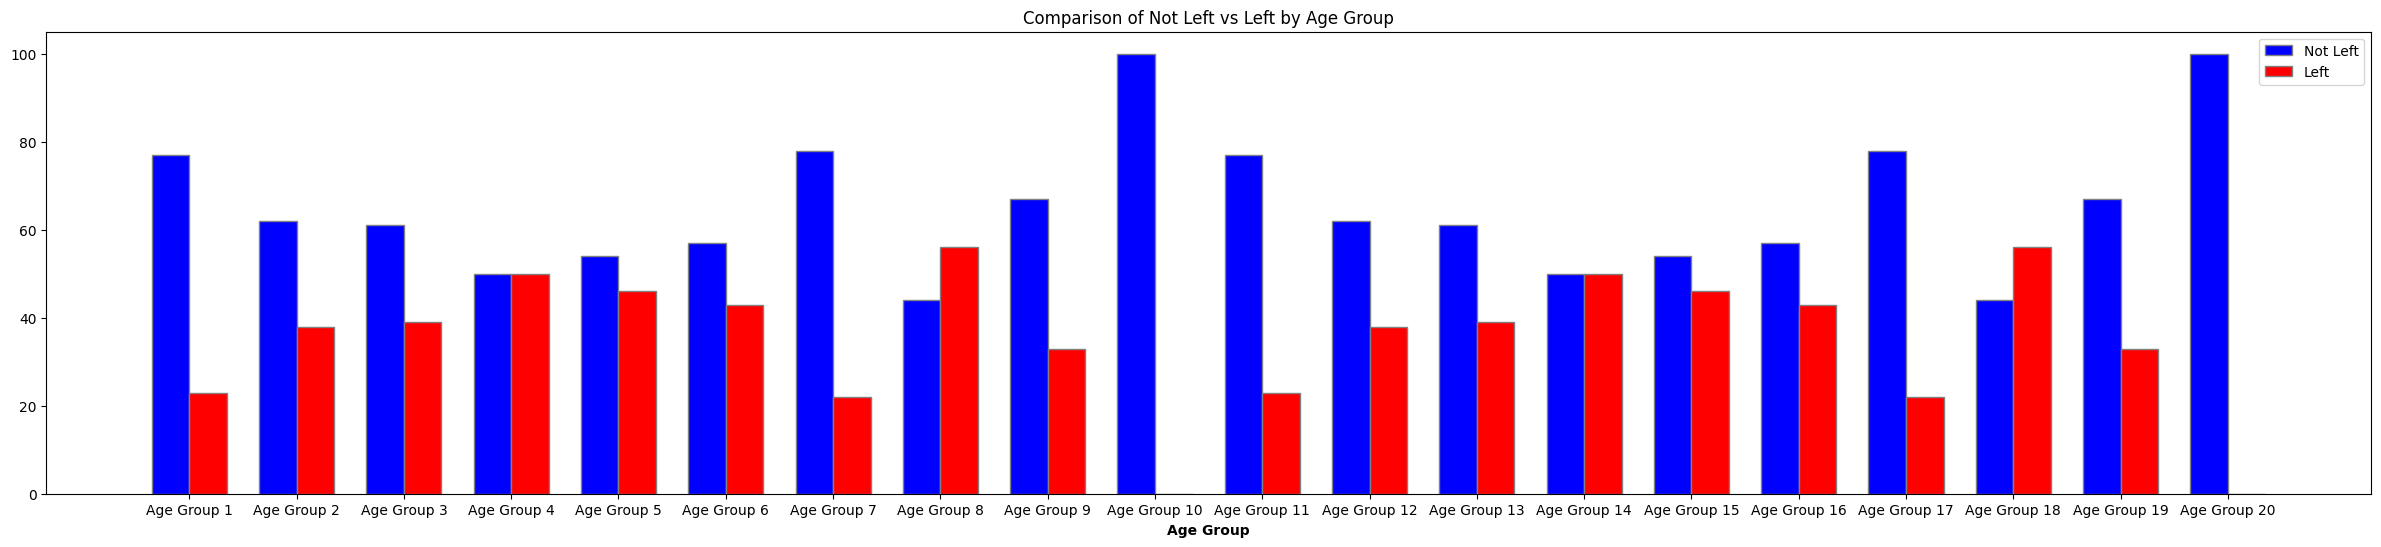

In [204]:
import matplotlib.pyplot as plt

# Define the labels for the bars
labels = [f'Age Group {i+1}' for i in range(len(comdataD))]

# Unzip the comdata into two separate lists
not_left, left = zip(*comdataD)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(not_left))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.figure(figsize=(30, 6))
plt.bar(r1, not_left, color='blue', width=bar_width, edgecolor='grey', label='Not Left')
plt.bar(r2, left, color='red', width=bar_width, edgecolor='grey', label='Left')

# Add labels to the x-axis
plt.xlabel('Age Group', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(not_left))], labels)

# Add a title and legend
plt.title('Comparison of Not Left vs Left by Age Group')
plt.legend()

# Show the plot
plt.show()

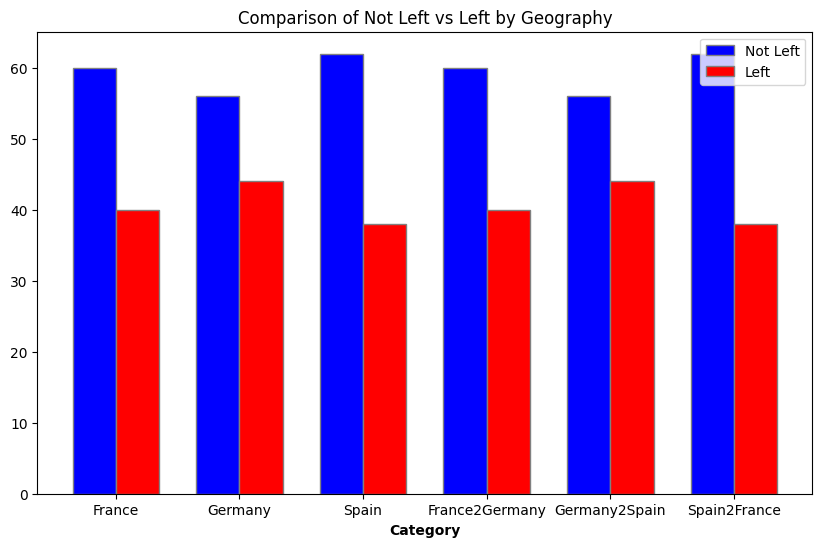

In [190]:
import matplotlib.pyplot as plt

# Define the labels for the bars
labels = ['France', 'Germany', 'Spain', 'France2Germany', 'Germany2Spain', 'Spain2France']

# Unzip the comdata into two separate lists
not_left, left = zip(*comdataD)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(not_left))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(r1, not_left, color='blue', width=bar_width, edgecolor='grey', label='Not Left')
plt.bar(r2, left, color='red', width=bar_width, edgecolor='grey', label='Left')

# Add labels to the x-axis
plt.xlabel('Category', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(not_left))], labels)

# Add a title and legend
plt.title('Comparison of Not Left vs Left by Geography')
plt.legend()

# Show the plot
plt.show()

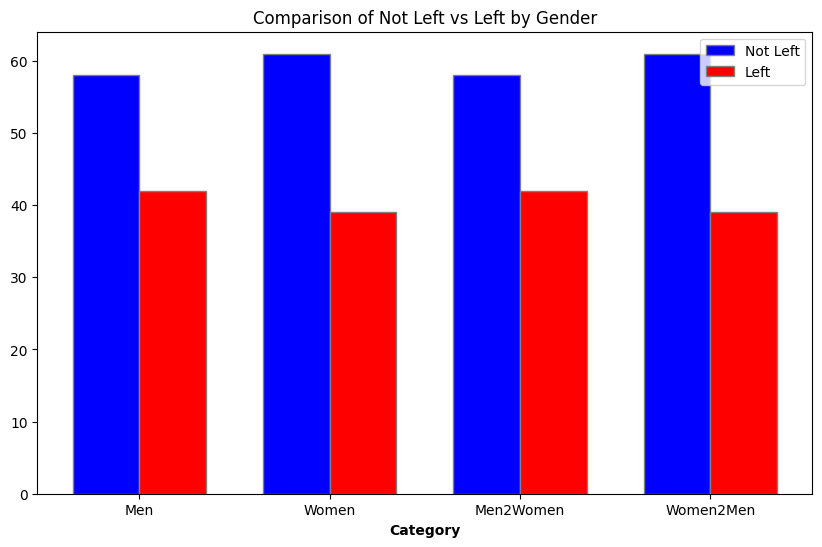

In [216]:
import matplotlib.pyplot as plt

# Define the labels for the bars
labels = ['Men', 'Women', 'Men2Women', 'Women2Men']

# Unzip the comdata into two separate lists
not_left, left = zip(*comdataD)

# Set the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(not_left))
r2 = [x + bar_width for x in r1]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(r1, not_left, color='blue', width=bar_width, edgecolor='grey', label='Not Left')
plt.bar(r2, left, color='red', width=bar_width, edgecolor='grey', label='Left')

# Add labels to the x-axis
plt.xlabel('Category', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(not_left))], labels)

# Add a title and legend
plt.title('Comparison of Not Left vs Left by Gender')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# men_1 = predicted[DatasetInvL.X_test[unfair_features].values == 0]
# women_1 = predicted[DatasetInvL.X_test[unfair_features].values == 1]

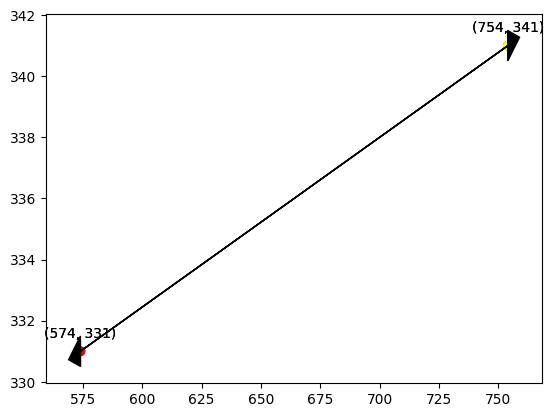

In [ ]:
# x = [len(men_0[men_0 == 0]), len(women_0[women_0 == 0]), len(men_1[men_1 == 0]), len(women_1[women_1 == 0])]
# y = [len(men_0[men_0 == 1]), len(women_0[women_0 == 1]), len(men_1[men_1 == 1]), len(women_1[women_1 == 1])]
# plt.figure(0)
# plt.scatter(x, y,c=['blue', 'green', 'yellow', 'red'])
# # plt.plot(x[:2], y[:2], 'k-', lw=2)
# plt.arrow(x[0], y[0], x[1] - x[0], y[1] - y[0], head_width=1, head_length=5, fc='k', ec='k')
# plt.arrow(x[2], y[2], x[3] - x[2], y[3] - y[2], head_width=1, head_length=5, fc='k', ec='k')
# for i in range(len(x)):
#     plt.annotate(f'({x[i]}, {y[i]})', (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')
# plt.savefig("outputs/output_with_out_Gender_unfairness_bank1.png")
# # plt.plot(x[2:], y[2:], 'k-', lw=2)